# Qcodes example with Andor iDus416

This driver has been tested with a iDus416 CCD with SDK version 2.102.30013.0.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib widget
from qcodes_contrib_drivers.drivers.Andor.Andor_iDus4xx import AndorIDus4xx

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\Flash\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : C:\Users\Flash\.qcodes\logs\231129-20632-qcodes.log


In [2]:
ccd = AndorIDus4xx('ccd')
ccd.set_temperature(-60)
ccd.cool_down()

Connected to: Andor DU416_LD,DD (serial:19023, firmware:9.2) in 6.66s


ccd cooling down to -60°C: 100%|██| -60/-60 [00:55<00:00, -1.09°C/s, DRV_TEMP_NOT_STABILIZED]


The CCD has different readout and acquisition modes which result in differently sized data. The central data parameter `ccd_data` has a dynamic shape depending on those settings.
- If the acquisition mode is a kinetic series, the first axis is a `TimeAxis` with size the number of frames, otherwise it is empty.
- The last axes correspond to the image dimensions, which may be 1d or 2d depending on the readout mode. If 2d, the y-axis (vertical dimension) is stored first.

In [3]:
print(ccd.acquisition_mode.vals, ccd.read_mode.vals, sep='\n')

<Enum: {'single scan', 'run till abort', 'accumulate', 'kinetics'}>
<Enum: {'image', 'random track', 'multi track', 'full vertical binning', 'single track'}>


To set up the camera for a measurement, first choose the acquisition and readout modes. Then apply other settings such as pre-amplifier gain, more settings specific to the chosen acquisition mode, and finally timing settings. Since exposure time, accumulation cycle time, and kinetic cycle time depend on each other, it is typically wise to set the one one cares most about first.

## Read modes
### Full vertical binning

In [4]:
def axis_label(param):
    return f'{param.label} ({param.unit})'

Text(0, 0.5, 'CCD Data (cts)')

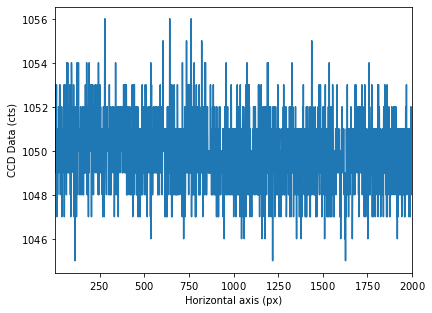

In [5]:
ccd.acquisition_mode('single scan')
ccd.read_mode('full vertical binning')
ccd.preamp_gain(1.)
# Shortest possible exposure time
ccd.exposure_time(0.)

fig, ax = plt.subplots()
ax.plot(ccd.ccd_data.setpoints[0].get(), ccd.ccd_data.get())
ax.set_xlabel(axis_label(ccd.ccd_data.setpoints[0]))
ax.set_ylabel(axis_label(ccd.ccd_data))

### Single track

Text(0, 0.5, 'CCD Data (cts)')

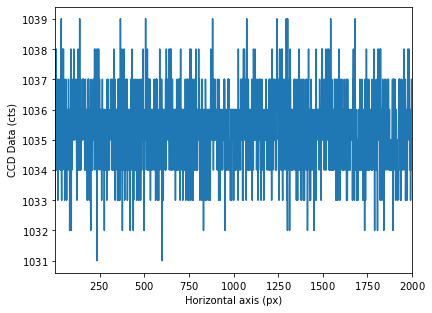

In [6]:
ccd.acquisition_mode('single scan')
ccd.read_mode('single track')
# A single track with center row 118 and 21 rows in height
ccd.single_track_settings((118, 21))

fig, ax = plt.subplots()
ax.plot(ccd.ccd_data.setpoints[0].get(), ccd.ccd_data.get())
ax.set_xlabel(axis_label(ccd.ccd_data.setpoints[0]))
ax.set_ylabel(axis_label(ccd.ccd_data))

### Multi track

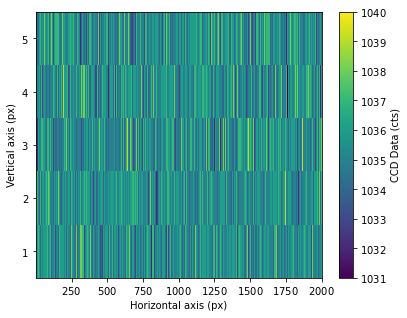

In [7]:
ccd.acquisition_mode('single scan')
ccd.read_mode('multi track')
# 5 tracks 10 px high and offset by 20 px from the bottom
ccd.multi_track_settings((5, 10, 20))

px, mt = np.meshgrid(*(sp.get() for sp in ccd.ccd_data.setpoints), indexing='ij')
fig, ax = plt.subplots()
img = ax.pcolormesh(mt, px, ccd.ccd_data.get(), shading='nearest')
ax.set_xlabel(axis_label(ccd.ccd_data.setpoints[1]))
ax.set_ylabel(axis_label(ccd.ccd_data.setpoints[0]))
fig.colorbar(img, label=axis_label(ccd.ccd_data))

### Random track

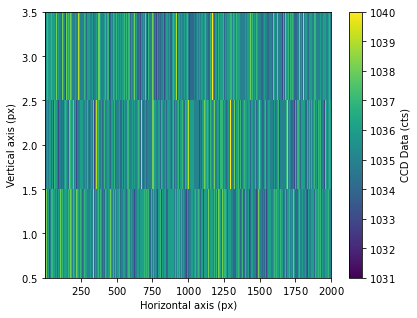

In [8]:
ccd.acquisition_mode('single scan')
ccd.read_mode('random track')
# 3 tracks; rows 10 to 20, rows 50 to 60, and rows 155 to 175
ccd.random_track_settings([3, (10, 20, 50, 60, 155, 175)])

px, rt = np.meshgrid(*(sp.get() for sp in ccd.ccd_data.setpoints), indexing='ij')
fig, ax = plt.subplots()
img = ax.pcolormesh(rt, px, ccd.ccd_data.get(), shading='nearest')
ax.set_xlabel(axis_label(ccd.ccd_data.setpoints[1]))
ax.set_ylabel(axis_label(ccd.ccd_data.setpoints[0]))
fig.colorbar(img, label=axis_label(ccd.ccd_data))

### Image

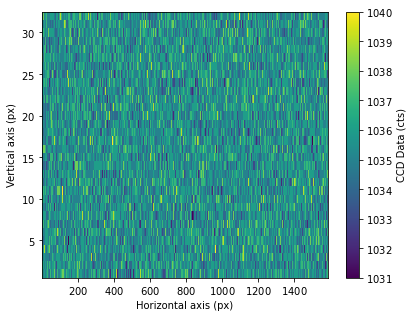

In [9]:
ccd.acquisition_mode('single scan')
ccd.read_mode('image')
# 1 px binned horizontally, 4 px binned vertically, crop from column 234 to 1821 and row 65 to 192.
ccd.image_settings((1, 4, 234, 1821, 65, 192))

pxx, pxy = np.meshgrid(*(sp.get() for sp in ccd.ccd_data.setpoints), indexing='ij')
fig, ax = plt.subplots()
img = ax.pcolormesh(pxy, pxx, ccd.ccd_data.get(), shading='nearest')
ax.set_xlabel(axis_label(ccd.ccd_data.setpoints[1]))
ax.set_ylabel(axis_label(ccd.ccd_data.setpoints[0]))
fig.colorbar(img, label=axis_label(ccd.ccd_data))

## Acquisition modes
### Accumulate

0.06735000014305115 0.03585999831557274


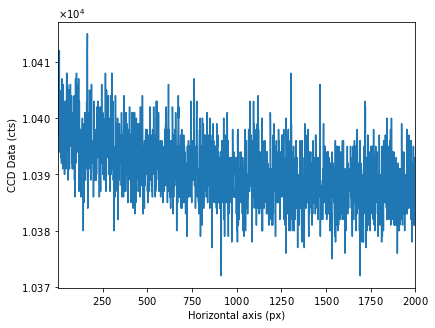

In [10]:
ccd.acquisition_mode('accumulate')
ccd.read_mode('full vertical binning')
# 10 sets of data accumulated into one image
ccd.number_accumulations(10)
ccd.accumulation_cycle_time(0.05)
ccd.exposure_time(0)

fig, ax = plt.subplots()
ax.plot(ccd.ccd_data.setpoints[0].get(), ccd.ccd_data.get())
ax.set_xlabel(axis_label(ccd.ccd_data.setpoints[0]))
ax.set_ylabel(axis_label(ccd.ccd_data))
print(ccd.accumulation_cycle_time(), ccd.exposure_time())

### Kinetics

0.2019599974155426 0.1009799987077713 0.03585999831557274


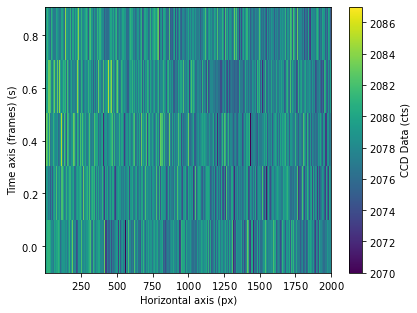

In [11]:
ccd.acquisition_mode('kinetics')
ccd.number_accumulations(2)
ccd.number_kinetics(5)
# 2 sets of data accumulated into one image five times in a row
ccd.kinetic_cycle_time(0.1)
ccd.accumulation_cycle_time(0.05)
ccd.exposure_time(0)

px, t = np.meshgrid(*(sp.get() for sp in ccd.ccd_data.setpoints), indexing='ij')
fig, ax = plt.subplots()
img = ax.pcolormesh(t, px, ccd.ccd_data.get(), shading='nearest')
ax.set_xlabel(axis_label(ccd.ccd_data.setpoints[1]))
ax.set_ylabel(axis_label(ccd.ccd_data.setpoints[0]))
fig.colorbar(img, label=axis_label(ccd.ccd_data))
print(ccd.kinetic_cycle_time(), ccd.accumulation_cycle_time(), ccd.exposure_time())

### Run till abort
This mode could be used to implement a live view using a separate thread, but this is currenlty not implemented. Fetching data in this mode by getting `ccd_data` will result in the interpreter being blocked forever.

## Data processing
There exist also `DelegateParameter`s to `ccd_data` which implement different data modes similar to the Andor Solis application. These are
- `ccd_data_bg_corrected`: Data in counts with a background image subtracted
- `ccd_data_per_second`: Data in counts per second (counts divided by the exposure time)
- `ccd_data_bg_corrected_per_second`: Combination of the two

Text(0, 0.5, 'Horizontal axis (px)')

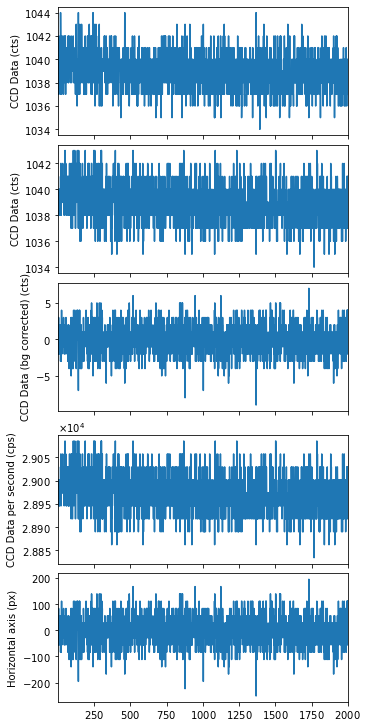

In [12]:
ccd.acquisition_mode('single scan')
ccd.read_mode('full vertical binning')
ccd.exposure_time(0.)

fig, ax = plt.subplots(5, sharex=True, layout='constrained', figsize=(5, 10))
ax[0].plot(ccd.ccd_data.setpoints[0].get(), ccd.background.get())
ax[0].set_ylabel(axis_label(ccd.background))
ax[1].plot(ccd.ccd_data.setpoints[0].get(), ccd.ccd_data.get())
ax[1].set_ylabel(axis_label(ccd.ccd_data))
ax[2].plot(ccd.ccd_data.setpoints[0].get(), ccd.ccd_data_bg_corrected.get_latest())
ax[2].set_ylabel(axis_label(ccd.ccd_data_bg_corrected))
ax[3].plot(ccd.ccd_data.setpoints[0].get(), ccd.ccd_data_per_second.get_latest())
ax[3].set_ylabel(axis_label(ccd.ccd_data_per_second))
ax[4].plot(ccd.ccd_data.setpoints[0].get(), ccd.ccd_data_bg_corrected_per_second.get_latest())
ax[4].set_ylabel(axis_label(ccd.ccd_data_bg_corrected_per_second))
ax[4].set_ylabel(axis_label(ccd.ccd_data.setpoints[0]))

In [13]:
ccd.close()